In [1]:
import numpy as np 
import torch
import matplotlib.pyplot as plt
from imageio import imread, imwrite
from torch import nn
import random

In [2]:
import sys
sys.path.append("..")
# from steganogan.decoders import DenseDecoderNLayers
from steganogan.decoders import BasicDecoder, DenseDecoder, DenseDecoderNLayers
from steganogan import SteganoGAN

In [3]:
import torch
import torchvision
from torch.optim import LBFGS
import torch.nn.functional as F

In [4]:
from tqdm import tqdm, trange

In [5]:
def shuffle_params(m):
    if type(m)==nn.Conv2d or type(m)==nn.BatchNorm2d:
        param = m.weight
        m.weight.data = nn.Parameter(torch.tensor(np.random.normal(0, 1, param.shape)).float())
        
        param = m.bias
        m.bias.data = nn.Parameter(torch.zeros(len(param.view(-1))).float().reshape(param.shape))
    if type(m)==nn.BatchNorm2d:
        if "track_running_stats" in m.__dict__:
            m.track_running_stats=False

            
def shuffle(t):
    idx = torch.randperm(t.numel())
    t = t.view(-1)[idx].view(t.shape)
    return t


In [6]:
class normLayer(nn.Module):
    def __init__(self):
        super(normLayer, self).__init__()
    def forward(self, x):
        b,c,h,w = x.shape
        assert b == 1
        mean = x.view(c, -1).mean(-1)
        std = x.view(c, -1).std(-1)
        x = x - mean.reshape([1, c, 1, 1])
        x = x / (std + 1e-7).reshape([1,c,1,1])
        return x

In [7]:
class BasicDecoder(nn.Module):
    """
    The BasicDecoder module takes an steganographic image and attempts to decode
    the embedded data tensor.

    Input: (N, 3, H, W)
    Output: (N, D, H, W)
    """

    def _conv2d(self, in_channels, out_channels):
        return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )

    def _build_models(self):
        self.layers = nn.Sequential(
            self._conv2d(self.divstack * self.divstack * (1 if self.flatten_image else 3), self.hidden_size),
            nn.LeakyReLU(inplace=True),
            normLayer() if self.yan_norm else nn.BatchNorm2d(self.hidden_size),

            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            normLayer() if self.yan_norm else nn.BatchNorm2d(self.hidden_size),

            self._conv2d(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(inplace=True),
            normLayer() if self.yan_norm else nn.BatchNorm2d(self.hidden_size),
#             self._conv2d(self.hidden_size, 2)
            self._conv2d(self.hidden_size, self.data_depth * self.divstack * self.divstack // 3 if self.flatten_image else self.data_depth * self.divstack * self.divstack)
        )

        return [self.layers]

    def __init__(self, data_depth, hidden_size, yan_norm=False, divstack=1, flatten_image=False):
        super().__init__()
        self.version = '1'
        self.data_depth = data_depth
        self.hidden_size = hidden_size
        self.yan_norm = yan_norm
        self.divstack = divstack
        self.flatten_image = flatten_image

        self._models = self._build_models()

    def upgrade_legacy(self):
        """Transform legacy pretrained models to make them usable with new code versions."""
        # Transform to version 1
        if not hasattr(self, 'version'):
            self._models = [self.layers]

            self.version = '1'

    def forward(self, x):
        x = self._models[0](x)

        if len(self._models) > 1:
            x_list = [x]
            for layer in self._models[1:]:
                x = layer(torch.cat(x_list, dim=1))
                x_list.append(x)

        return x

In [8]:
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
criterion1 = torch.nn.L1Loss(reduction='sum')
criterion2 = torch.nn.MSELoss(reduction='sum')

def pad(x, reweight=7):
    return torch.cat([x.view(-1), torch.zeros(reweight-1-(x.numel()-1) % reweight).to(x.dtype).to(x.device)]).view(-1, reweight)

def get_loss(outputs, target, loss_mode, reweight=0):
    outputs = model(adv_image)
    if loss_mode == "BCE":
        loss = criterion(outputs, target)
    elif loss_mode == "log":
        loss = -(target * 2 - 1) * outputs
        loss = torch.nn.functional.softplus(loss)  # log(1+exp(x))
        loss = torch.sum(loss)
    elif loss_mode == "hingelog":
        loss = -(target * 2 - 1) * outputs
        loss = torch.nn.functional.softplus(loss)  # log(1+exp(x))
        loss = torch.max(loss-hinge, torch.zeros(target.shape).to(target.device))
        loss = torch.sum(loss)
    elif loss_mode == "L1":
        outputs = F.sigmoid(outputs) * 255
        loss = criterion1(outputs, target)
    elif loss_mode == "L2":
        outputs = F.sigmoid(outputs) * 255
        loss = criterion2(outputs, target)
        
    if reweight > 0:
        correctness = (outputs > 0).long() != target.long()
        correctness = pad(correctness, reweight)
        loss_mask = (torch.sum(correctness, dim=1) > 1).float().view(-1, 1)
        loss = torch.sum(pad(loss, reweight) * loss_mask)
        loss.backward()
    return loss

In [9]:
import torch.nn.functional as F
def pad(image, divstack):
    _, _, h, w = image.shape
    xblock = ((h-1) // divstack) + 1
    xpad = xblock * divstack - h
    yblock = ((w-1) // divstack) + 1
    ypad = yblock * divstack - w
    image = F.pad(image, (0, ypad, 0, xpad), "constant", 0)
    crops = []
    for i in range(divstack):
        for j in range(divstack):
            crops.append(image[:, :, i*xblock:(i+1)*xblock, j*xblock:(j+1)*xblock])
    return torch.cat(crops, dim=1)

In [10]:
def flatten(image, dim=3):
    img = torch.cat(torch.split(image, 1, dim=1), dim=dim)
    return img

In [15]:
num_bits = 4
divstack = 1
yan_norm = True
shuffle_image = False
flatten_image = True
# models
model_name = "steg_decode_new"
if model_name == "steg_decode":
#     steganogan = SteganoGAN.load(architecture='dense', path=None, cuda=True, verbose=True)
    steganogan = SteganoGAN.load(path="demo_1.1.steg", cuda=True, verbose=True)
    model = steganogan.decoder
    model.apply(shuffle_params)
elif model_name == "steg_decode_new":
    model = BasicDecoder(num_bits, hidden_size=128, yan_norm=yan_norm, divstack=divstack, flatten_image=flatten_image)
    model.apply(shuffle_params)
    model.to('cuda')
else:
    print("unknown model")

model.to('cuda')
if not yan_norm:
    print(model.layers[2].track_running_stats)
old_dict = model.state_dict()

In [16]:
# extract a bit vector
# image = "/home/vk352/FaceDetection/datasets/sample/obama2.jpg"
image = "/home/vk352/FaceDetection/datasets/data512x512/00001.jpg"
image = imread(image, pilmode='RGB') / 255.0
image = torch.FloatTensor(image).permute(2, 1, 0).unsqueeze(0)
image = image.to('cuda')
if divstack > 1:
    image = pad(image, divstack)
if shuffle_image:
    image = shuffle(image)
if flatten_image:
    image = flatten(image, 3)

print(image.shape)
out = model(image)
# image = self.decoder(image).view(-1) > 0

torch.Size([1, 1, 512, 1536])


In [17]:
target = torch.bernoulli(torch.empty(out.shape).uniform_(0, 1)).to(out.device)
# target = torch.empty(out.shape).random_(256).to(out.device)
print(target.shape)
# del out

torch.Size([1, 1, 512, 1536])


In [18]:
loss_mode = "log"
hinge = 0.3

In [19]:
# lbfgs

lbfgsacc = {}
lbfgsimg = {}

steps = 1000
eps = 0.2
adv_image = image.clone().detach()
max_iter = 20

for alpha in [0.3]:
    adv_image = image.clone().detach()
    print("alpha:", alpha)
    accuracy = []

    for i in trange(steps // max_iter):
        adv_image.requires_grad = True
        optimizer = LBFGS([adv_image], lr=alpha, max_iter=max_iter)

        def closure():
            loss = get_loss(adv_image, target, loss_mode)

            optimizer.zero_grad()
            loss.backward()
            return loss

        optimizer.step(closure)
        delta = torch.clamp(adv_image - image, min=-eps, max=eps)
        adv_image = torch.clamp(image + delta, min=0, max=1)
        adv_image = torch.clamp(adv_image*255, 0, 255).int().float()/255.
        adv_image = adv_image.detach()
        
        if loss_mode in ["L1", "L2"]:
            acc = len(torch.nonzero(torch.abs(F.sigmoid(model(adv_image)).float().view(-1)*255-target.view(-1)) > 128)) / target.numel()
        else:
            acc = len(torch.nonzero((model(adv_image)>0).float().view(-1) != target.view(-1))) / target.numel()
        print("error", acc)
        accuracy.append(acc)

    lbfgsacc[alpha] = accuracy
#     lbfgsimg[alpha] = adv_image.cpu().squeeze().permute(2,1,0)

alpha: 0.3


  2%|▏         | 1/50 [00:06<05:02,  6.16s/it]

error 0.42688751220703125


  4%|▍         | 2/50 [00:12<04:54,  6.14s/it]

error 0.42378489176432294


  6%|▌         | 3/50 [00:18<04:48,  6.13s/it]

error 0.42054494222005206


  8%|▊         | 4/50 [00:24<04:41,  6.13s/it]

error 0.4208170572916667


 10%|█         | 5/50 [00:30<04:35,  6.13s/it]

error 0.42005157470703125


 12%|█▏        | 6/50 [00:36<04:29,  6.13s/it]

error 0.42102686564127606


 14%|█▍        | 7/50 [00:42<04:24,  6.14s/it]

error 0.4208335876464844


 16%|█▌        | 8/50 [00:49<04:18,  6.15s/it]

error 0.4199409484863281


 18%|█▊        | 9/50 [00:55<04:12,  6.16s/it]

error 0.41997400919596356


 20%|██        | 10/50 [01:01<04:06,  6.16s/it]

error 0.4201215108235677


 22%|██▏       | 11/50 [01:07<04:00,  6.17s/it]

error 0.4212608337402344


 24%|██▍       | 12/50 [01:13<03:54,  6.18s/it]

error 0.42055002848307294


 26%|██▌       | 13/50 [01:20<03:48,  6.19s/it]

error 0.4204978942871094


 28%|██▊       | 14/50 [01:26<03:42,  6.19s/it]

error 0.4207750956217448


 30%|███       | 15/50 [01:32<03:36,  6.19s/it]

error 0.4200604756673177


 32%|███▏      | 16/50 [01:38<03:30,  6.20s/it]

error 0.4206695556640625


 34%|███▍      | 17/50 [01:44<03:24,  6.21s/it]

error 0.4203300476074219


 36%|███▌      | 18/50 [01:51<03:18,  6.21s/it]

error 0.4197731018066406


 38%|███▊      | 19/50 [01:57<03:12,  6.22s/it]

error 0.4202461242675781


 40%|████      | 20/50 [02:03<03:06,  6.22s/it]

error 0.4208056131998698


 42%|████▏     | 21/50 [02:09<03:00,  6.22s/it]

error 0.42032496134440106


 44%|████▍     | 22/50 [02:15<02:54,  6.22s/it]

error 0.4208030700683594


 46%|████▌     | 23/50 [02:22<02:47,  6.22s/it]

error 0.42104212443033856


 48%|████▊     | 24/50 [02:28<02:41,  6.22s/it]

error 0.4207814534505208


 50%|█████     | 25/50 [02:34<02:35,  6.23s/it]

error 0.41911061604817706


 52%|█████▏    | 26/50 [02:40<02:29,  6.23s/it]

error 0.4207166035970052


 54%|█████▍    | 27/50 [02:47<02:23,  6.24s/it]

error 0.4200884501139323


 56%|█████▌    | 28/50 [02:53<02:17,  6.24s/it]

error 0.4210357666015625


 58%|█████▊    | 29/50 [02:59<02:10,  6.24s/it]

error 0.4203084309895833


 60%|██████    | 30/50 [03:05<02:04,  6.24s/it]

error 0.42089207967122394


 62%|██████▏   | 31/50 [03:12<01:58,  6.24s/it]

error 0.41965357462565106


 64%|██████▍   | 32/50 [03:18<01:52,  6.25s/it]

error 0.420806884765625


 66%|██████▌   | 33/50 [03:24<01:46,  6.24s/it]

error 0.4203948974609375


 68%|██████▊   | 34/50 [03:30<01:39,  6.24s/it]

error 0.4199625651041667


 70%|███████   | 35/50 [03:37<01:33,  6.26s/it]

error 0.4213460286458333


 72%|███████▏  | 36/50 [03:43<01:27,  6.26s/it]

error 0.41965993245442706


 74%|███████▍  | 37/50 [03:49<01:21,  6.26s/it]

error 0.4198137919108073


 76%|███████▌  | 38/50 [03:55<01:15,  6.26s/it]

error 0.42057545979817706


 78%|███████▊  | 39/50 [04:02<01:09,  6.28s/it]

error 0.4202613830566406


 80%|████████  | 40/50 [04:08<01:02,  6.27s/it]

error 0.4209327697753906


 82%|████████▏ | 41/50 [04:14<00:56,  6.26s/it]

error 0.42081451416015625


 84%|████████▍ | 42/50 [04:21<00:50,  6.26s/it]

error 0.42061614990234375


 86%|████████▌ | 43/50 [04:27<00:43,  6.28s/it]

error 0.42034149169921875


 88%|████████▊ | 44/50 [04:33<00:37,  6.27s/it]

error 0.42023976643880206


 90%|█████████ | 45/50 [04:39<00:31,  6.30s/it]

error 0.4197095235188802


 92%|█████████▏| 46/50 [04:46<00:25,  6.28s/it]

error 0.4216117858886719


 94%|█████████▍| 47/50 [04:52<00:18,  6.30s/it]

error 0.4207305908203125


 96%|█████████▌| 48/50 [04:58<00:12,  6.29s/it]

error 0.41979217529296875


 98%|█████████▊| 49/50 [05:05<00:06,  6.29s/it]

error 0.41972096761067706


100%|██████████| 50/50 [05:11<00:00,  6.23s/it]

error 0.4203961690266927


torch.Size([1536, 512, 1])


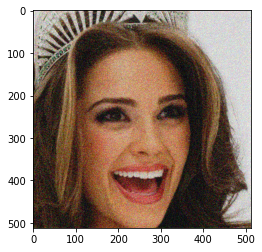

In [34]:
img = adv_image.cpu().squeeze(0).permute(2, 1, 0)
print(img.shape)
img = torch.cat(torch.split(img, 512, dim=0), dim=2)
plt.imshow(img)

In [2]:
import numpy as np
np.std(adv_image - image)

NameError: name 'adv_image' is not defined

# max_iter = 20

No handles with labels found to put in legend.


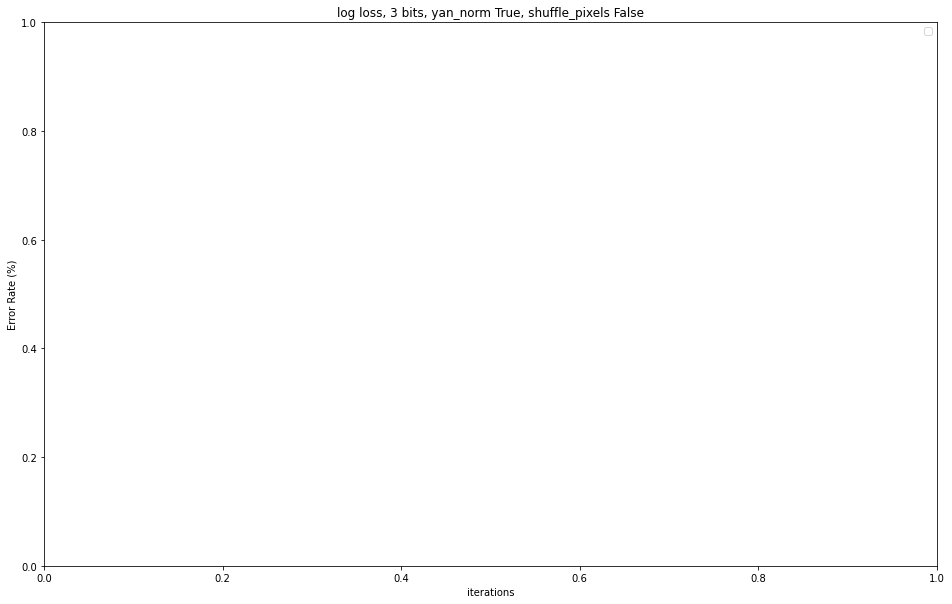

In [16]:
plt.figure(figsize=(16, 10))
# plt.plot(range(1000), np.array(bceacc) * 100, label="SGD")
for lr, acc in lbfgsacc.items():
    plt.plot(np.arange(1, steps // max_iter + 1) * max_iter, np.array(acc[:steps // max_iter]) * 100, label=f"LBFGS lr {lr}")
plt.legend()
plt.ylabel("Error Rate (%)")
plt.xlabel("iterations")
plt.title(f"{loss_mode} loss, {num_bits} bits, yan_norm {yan_norm}, shuffle_pixels {shuffle_image}")
# plt.ylim(0, 0.01)
plt.show()

In [92]:
new_weights = model.state_dict()

In [96]:
for k in new_weights.keys():
    print(k, torch.norm(old_dict[k].float() - new_weights[k].float()))

layers.0.weight tensor(0., device='cuda:0')
layers.0.bias tensor(0., device='cuda:0')
layers.2.weight tensor(0., device='cuda:0')
layers.2.bias tensor(0., device='cuda:0')
layers.2.running_mean tensor(0., device='cuda:0')
layers.2.running_var tensor(0., device='cuda:0')
layers.2.num_batches_tracked tensor(0., device='cuda:0')
layers.3.weight tensor(0., device='cuda:0')
layers.3.bias tensor(0., device='cuda:0')
layers.5.weight tensor(0., device='cuda:0')
layers.5.bias tensor(0., device='cuda:0')
layers.5.running_mean tensor(0., device='cuda:0')
layers.5.running_var tensor(0., device='cuda:0')
layers.5.num_batches_tracked tensor(0., device='cuda:0')
layers.6.weight tensor(0., device='cuda:0')
layers.6.bias tensor(0., device='cuda:0')
layers.8.weight tensor(0., device='cuda:0')
layers.8.bias tensor(0., device='cuda:0')
layers.8.running_mean tensor(0., device='cuda:0')
layers.8.running_var tensor(0., device='cuda:0')
layers.8.num_batches_tracked tensor(0., device='cuda:0')
layers.9.weight 

In [32]:
accs.keys()

dict_keys(['hingelogacc', 'bceacc', 'hingeacc', 'logacc'])

In [31]:
import pickle
with open("accs.pkl", "rb") as f:
    accs = pickle.load(f)

In [245]:
image.shape

torch.Size([1, 3, 450, 612])

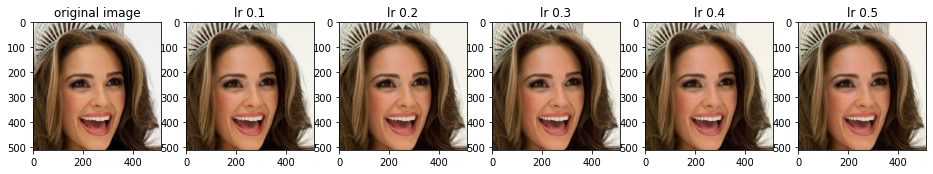

In [104]:
fig, axs = plt.subplots(1, len(lbfgsimg)+1, figsize=(16, 6))

axs[0].imshow(image.cpu().squeeze().permute(2,1,0))
axs[0].set_title("original image")
for i, alpha in enumerate([0.1, 0.2, 0.3, 0.4, 0.5]):
    axs[i+1].imshow(lbfgsimg[alpha])
    axs[i+1].set_title(f"lr {alpha}")

In [170]:
print("Number of Incorrect bits:")
print(len(torch.nonzero(output.float().view(-1) != target.view(-1))))
print("Total bits:")
print(target.numel())
print("Error rate:")
print(len(torch.nonzero(output.float().view(-1) != target.view(-1))) / target.numel())

Number of Incorrect bits:
44
Total bits:
275400
Error rate:
0.0001597676107480029


In [105]:
# lbfgs2

lbfgsacc = {}
lbfgsimg = {}

steps = 2000
eps = 0.2
adv_image = image.clone().detach()
max_iter = 20

for alpha in [0.1, 0.2, 0.3, 0.4, 0.5]:
    print("alpha:", alpha)
    accuracy = []

    for i in trange(steps // max_iter):
        adv_image.requires_grad = True
        optimizer = LBFGS([adv_image], lr=alpha, max_iter=max_iter)

        def closure():
            outputs = model(adv_image)
            loss = get_loss(output, target, loss_mode) + criterion2(adv_image, image)

            optimizer.zero_grad()
            loss.backward()
            return loss

        optimizer.step(closure)
        delta = torch.clamp(adv_image - image, min=-eps, max=eps)
        adv_image = torch.clamp(image + delta, min=0, max=1).detach()

        acc = len(torch.nonzero((model(adv_image)>0).float().view(-1) != target.view(-1))) / target.numel()
        print(acc)
        accuracy.append(acc)

    lbfgsacc[alpha] = accuracy
    lbfgsimg[alpha] = adv_image.cpu().squeeze().permute(2,1,0)

100

Text(0.5, 1.0, 'StegExpose - Gaussian Noise on Original Images')

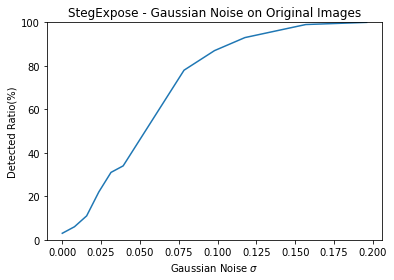

In [74]:
eps = np.array([0, 2, 4, 6, 8, 10, 20, 25, 30, 40, 50]) / 255.0
detect = [3, 6, 11, 22, 31, 34, 78, 87, 93, 99, 100]
plt.plot(eps, detect)
plt.xlabel(r"Gaussian Noise $\sigma$")
plt.ylabel("Detected Ratio(%)")
plt.ylim(0, 100)
plt.title("StegExpose - Gaussian Noise on Original Images")